# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_theme(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

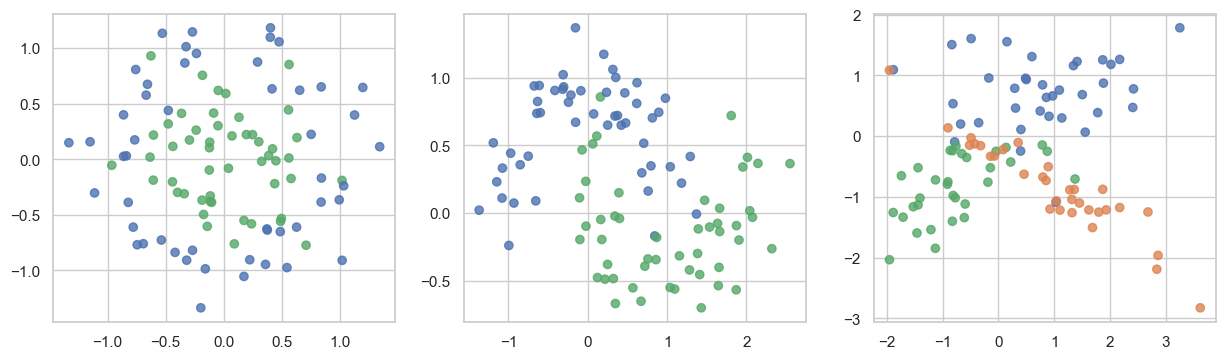

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

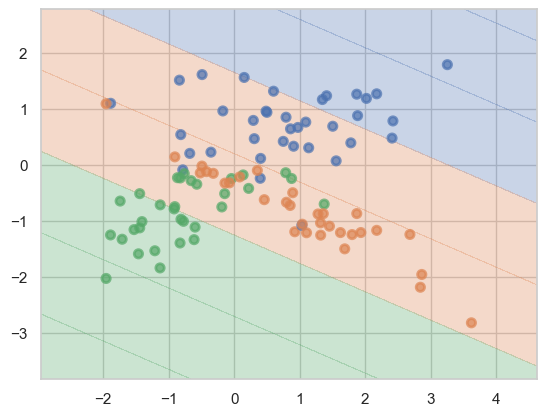

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

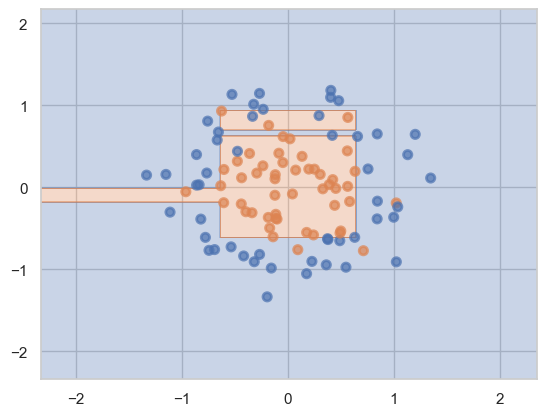

Dataset 1: train_acc = 1.0000, test_acc = 0.8333, переобучение = 0.1667


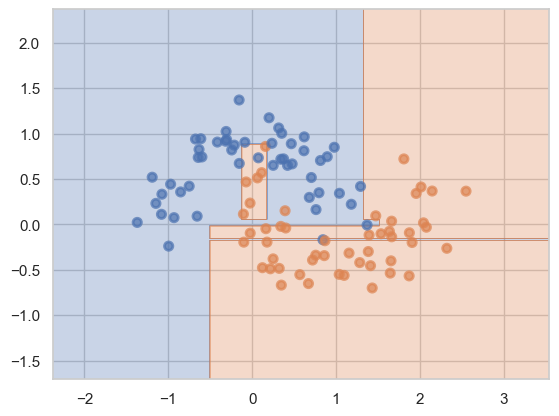

Dataset 2: train_acc = 1.0000, test_acc = 0.9333, переобучение = 0.0667


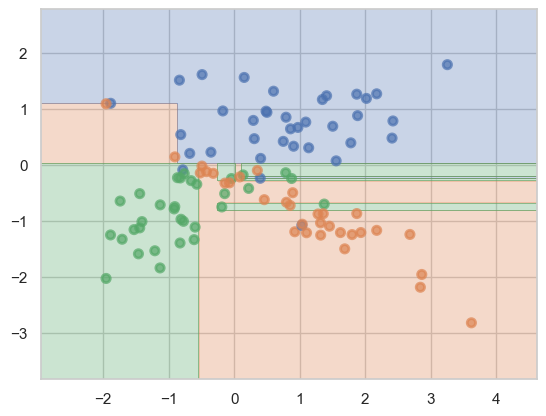

Dataset 3: train_acc = 1.0000, test_acc = 0.8000, переобучение = 0.2000


In [7]:

# Визуализация и обучение

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3 )
    
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit( X_train, y_train )
    
    acc_train = clf.score( X_train, y_train )
    acc_test = clf.score( X_test, y_test )
    
    plot_surface( clf, X, y )
    plt.show()
    
    print(f"Dataset {i+1}: train_acc = {acc_train:.4f}, test_acc = {acc_test:.4f}, "
          f"переобучение = {acc_train - acc_test:.4f}")


__Ответ:__ Деревья сильно переобучились: на всех трёх датасетах точность на обучающей выборке - 100%, на тестовой - ниже (от ~0.88 до ~0.93). Разрыв (train_acc − test_acc) от 6.7% до 11.4%, что говорит о явном переобучении.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

max_depth=2, min_samples_leaf=20 | Обучающая: 0.686, Тестовая: 0.700
max_depth=3, min_samples_leaf=10 | Обучающая: 0.886, Тестовая: 0.700
max_depth=5, min_samples_leaf=5 | Обучающая: 0.943, Тестовая: 0.833
max_depth=None, min_samples_leaf=1 | Обучающая: 1.000, Тестовая: 0.700
max_depth=2, min_samples_leaf=20 | Обучающая: 0.857, Тестовая: 0.767
max_depth=3, min_samples_leaf=10 | Обучающая: 0.857, Тестовая: 0.767
max_depth=5, min_samples_leaf=5 | Обучающая: 0.900, Тестовая: 0.800
max_depth=None, min_samples_leaf=1 | Обучающая: 1.000, Тестовая: 0.933
max_depth=2, min_samples_leaf=20 | Обучающая: 0.886, Тестовая: 0.800
max_depth=3, min_samples_leaf=10 | Обучающая: 0.886, Тестовая: 0.833
max_depth=5, min_samples_leaf=5 | Обучающая: 0.886, Тестовая: 0.833
max_depth=None, min_samples_leaf=1 | Обучающая: 1.000, Тестовая: 0.667


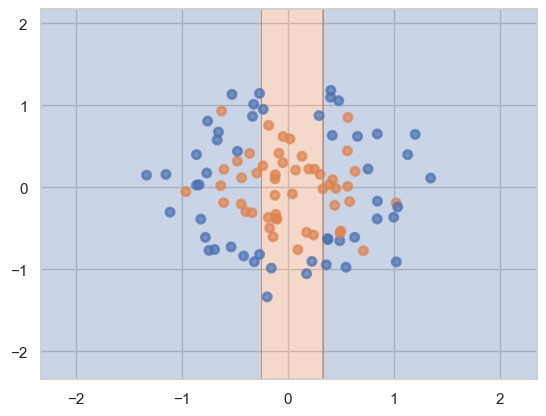

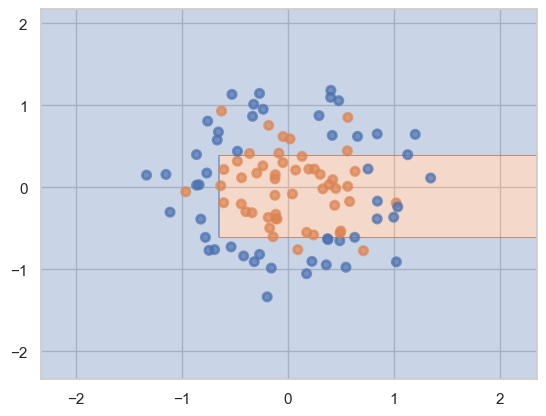

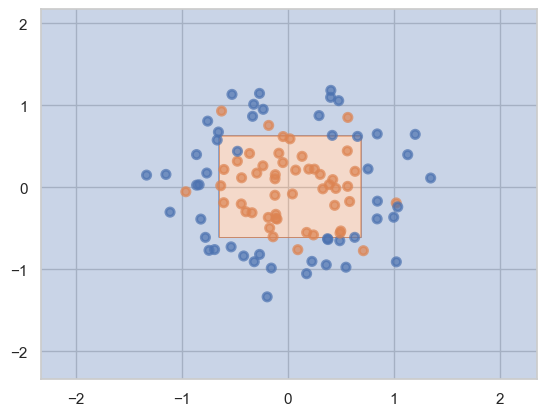

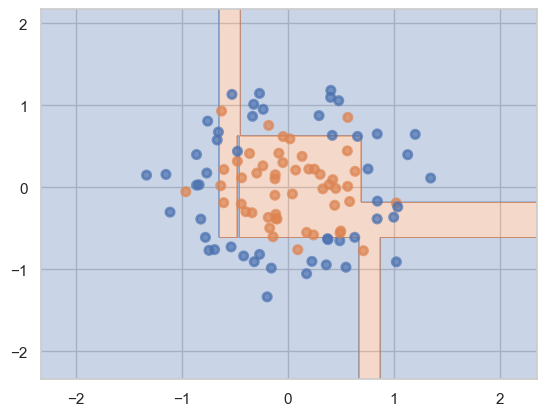

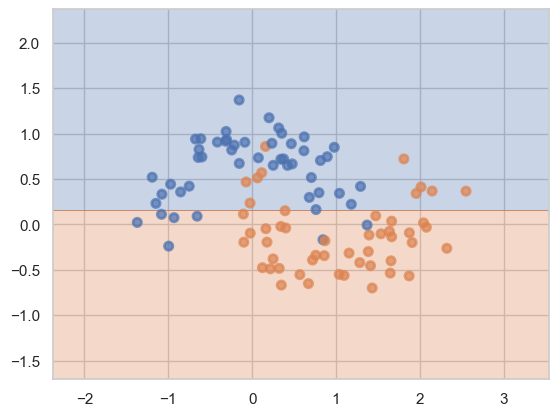

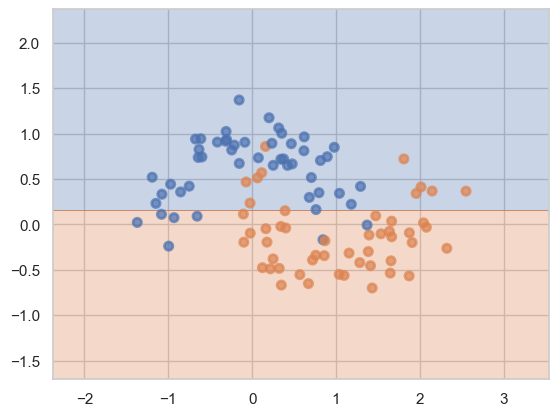

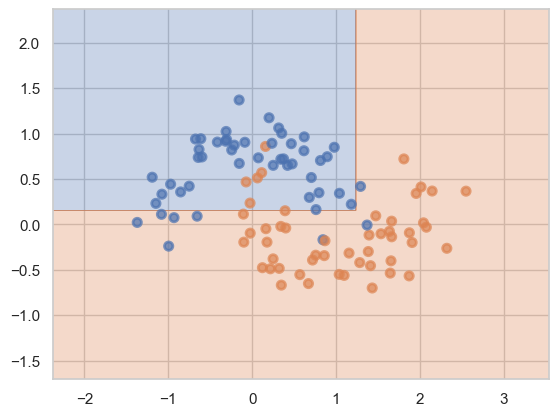

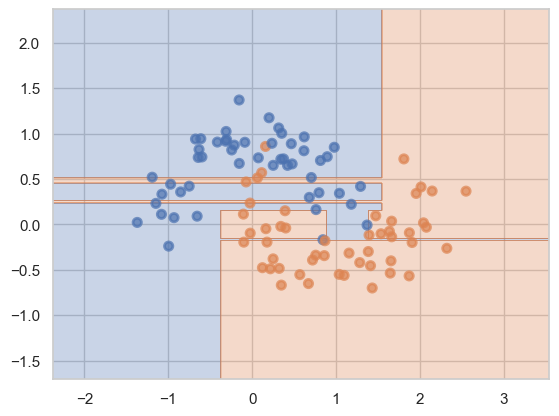

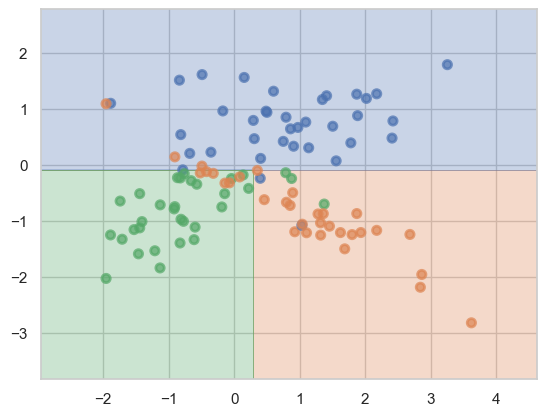

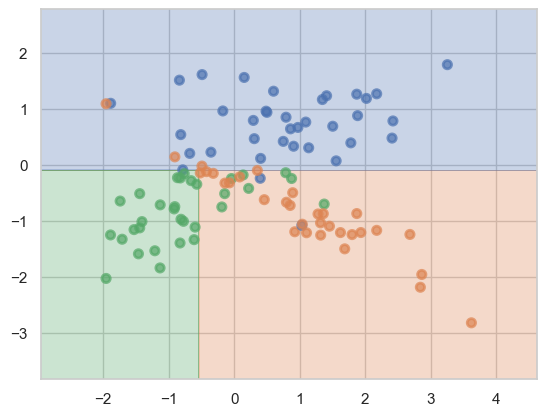

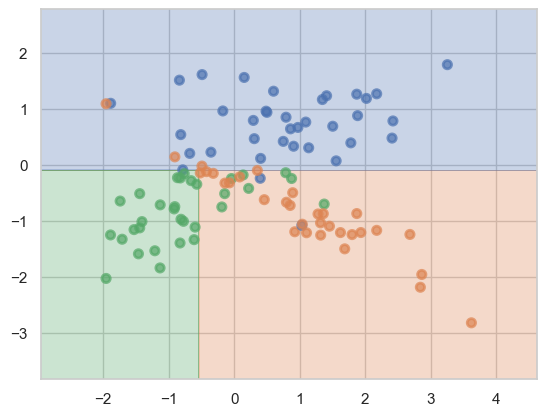

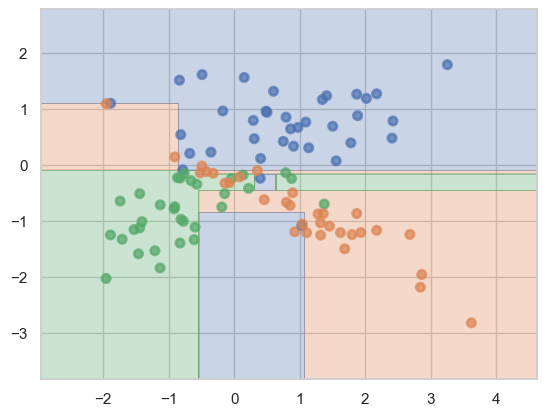

In [8]:
param_sets = [
    {"max_depth": 2, "min_samples_leaf": 20},
    {"max_depth": 3, "min_samples_leaf": 10},
    {"max_depth": 5, "min_samples_leaf": 5},
    {"max_depth": None, "min_samples_leaf": 1}
]

for X, y in datasets:
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42, stratify=y )
    
    for params in param_sets:
        clf = DecisionTreeClassifier( **params, random_state=42 )
        clf.fit( X_train, y_train )
        
        train_acc = clf.score( X_train, y_train )
        test_acc = clf.score( X_test, y_test )
        
        plt.figure()
        plot_surface( clf, X, y )
        print( f"max_depth={params['max_depth']}, min_samples_leaf={params['min_samples_leaf']} | Обучающая: {train_acc:.3f}, Тестовая: {test_acc:.3f}" )

__Ответ:__
Circles:

md=2, msl=20 -> train=0.767, test=0.778
md=3, msl=10 -> train=0.871, test=0.867
md=5, msl=5 -> train=0.960, test=0.911
md=inf, msl=1 -> train=1.000, test=0.867

При максимальной глубине обучающая accuracy = 1.0, но тестовая уменьшается на 4.4% по сравнению с md=5. Явное переобучение.

Moons:

md=2, msl=20 -> train=0.824, test=0.822
md=3, msl=10 -> train=0.922, test=0.911
md=5, msl=5 -> train=0.985, test=0.956
md=inf, msl=1 -> train=1.000, test=0.956
Переобучение значительно слабее, тестовая accuracy стабилизируется на 0.956 и не падает при md= inf.

3-Class:

md=2, msl=20 -> train=0.895, test=0.933
md=3, msl=10 -> train=0.974, test=0.956
md=5, msl=5 -> train=1.000, test=0.956
md=inf, msl=1 -> train=1.000, test=0.933
Уже при md =2 тестовая accuracy выше, чем при md=inf, серьезного влияния параметров на результат не наблюдается. Дополнительное увеличение глубины ухудшают обобщение.

Circles сильно страдает от переобучения при глубоких деревьях. Оптимум - md=5.
Moons умеренное переобучение, оптимум - md=5.
3-Class оптимум уже при md=3, увеличение глубины далее ухудшает обобщение на 2.3%
Чем сложнее граница (шум), тем лучше при умеренном усложнении - но риск переобучения выше.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

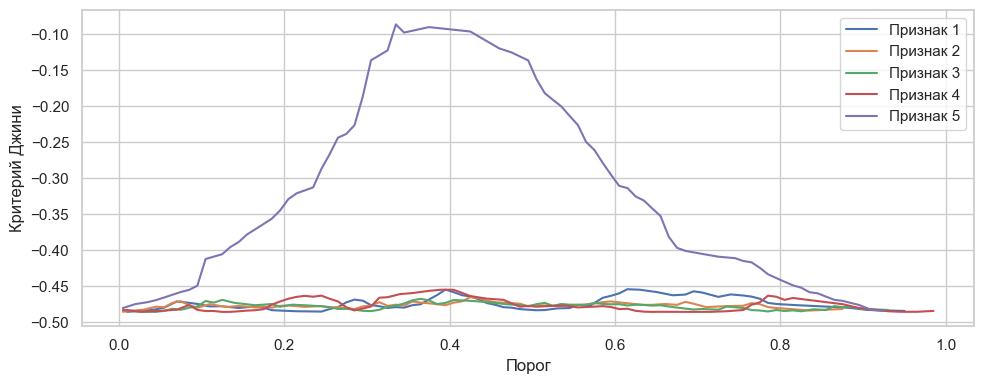

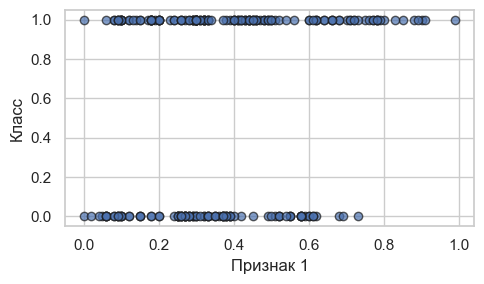

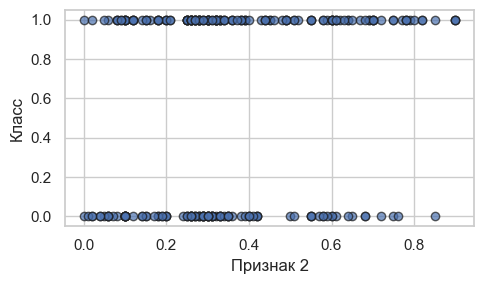

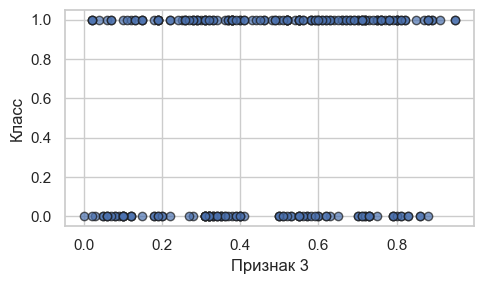

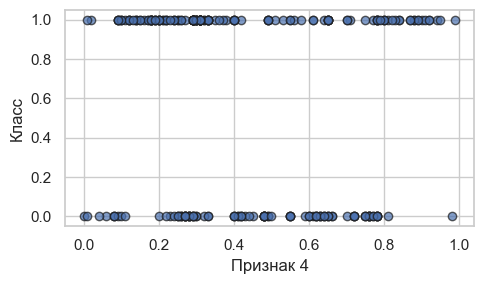

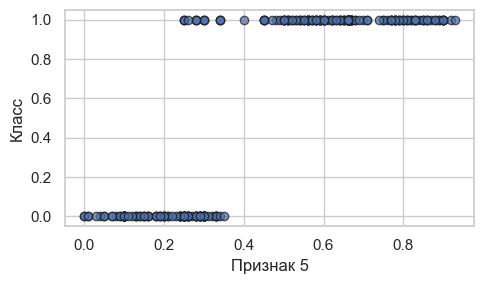

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv( "datasets/students.csv" )
X = df.iloc[:, :5].values
y = df.iloc[:, -1].values

def gini(y):
    if len(y) == 0: return 0.0
    p = np.mean(y)
    return 2 * p * (1 - p)

def q_gini(f, t, thr):
    left = f <= thr
    right = ~left
    nl, nr = left.sum(), right.sum()
    if nl == 0 or nr == 0: return -np.inf
    return -(nl / len(t)) * gini(t[left]) - (nr / len(t)) * gini(t[right])

plt.figure(figsize=(10, 4))
for i in range(5):
    f = X[:, i]
    idx = np.argsort(f)
    f_sorted = f[idx]
    thrs = (f_sorted[:-1] + f_sorted[1:]) / 2
    valid = f_sorted[1:] != f_sorted[:-1]
    thrs = thrs[valid]
    scores = np.array( [q_gini(f, y, thr) for thr in thrs] )
    plt.plot( thrs, scores, label=f"Признак {i+1}" )
plt.xlabel( "Порог" )
plt.ylabel( "Критерий Джини" )
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for i in range(5):
    plt.figure(figsize=(5, 3))
    plt.scatter(X[:, i], y, alpha=0.7, edgecolors="k")
    plt.xlabel(f"Признак {i+1}")
    plt.ylabel("Класс")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from hw2code import DecisionTree
from sklearn.metrics import accuracy_score

df = pd.read_csv( "datasets/agaricus-lepiota.data", header=None )
y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values

le_y = LabelEncoder()
y = le_y.fit_transform(y)  # e/p → 0/1

X_encoded = np.zeros_like(X, dtype=int)
for i in range( X.shape[1] ):
    le = LabelEncoder()
    X_encoded[:, i] = le.fit_transform(X[:, i])

X_train, X_test, y_train, y_test = train_test_split( X_encoded, y, test_size=0.5, random_state=42, stratify=y )

feature_types = ["categorical"] * X_encoded.shape[1]

tree = DecisionTree( feature_types=feature_types )
tree.fit( X_train, y_train )

y_pred = tree.predict( X_test )
acc = accuracy_score( y_test, y_pred )
acc

1.0

__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

def load_data():
    mush = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data", header=None)
    X_m = mush.iloc[:, 1:].values
    y_m = (mush.iloc[:, 0] == 'p').astype(int).values

    ttt = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data", header=None)
    X_t = ttt.iloc[:, :-1].values
    y_t = (ttt.iloc[:, -1] == 'positive').astype(int).values

    car = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data", header=None)
    X_c = car.iloc[:, :-1].values
    y_c = car.iloc[:, -1].map({'unacc':0, 'acc':0, 'good':1, 'vgood':1}).values

    nur = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data", header=None, na_values='?')
    nur = nur.dropna() 
    X_n = nur.iloc[:, :-1].values
    y_n = nur.iloc[:, -1].map({
        'not_recom':0, 'recommend':0,
        'very_recom':1, 'priority':1, 'spec_prior':1
    }).values

    return [("mushroom", X_m, y_m),
            ("tic_tac_toe", X_t, y_t),
            ("car", X_c, y_c),
            ("nursery", X_n, y_n)]


def encode_label(X):
    le = LabelEncoder()
    return np.stack([le.fit_transform(col) for col in X.T], axis=1).astype(float)

def encode_ohe(X):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    return ohe.fit_transform(X)

datasets = load_data()
scoring = make_scorer(accuracy_score)

for name, X, y in datasets:
    X_le = encode_label(X)
    X_ohe = encode_ohe(X)

    ft_real = ["real"] * X.shape[1]
    ft_cat = ["categorical"] * X.shape[1]
    ft_real_ohe = ["real"] * X_ohe.shape[1] 
    
    score_real = cross_val_score(DecisionTree(ft_real), X_le, y, cv=10, scoring=scoring).mean()
    score_cat = cross_val_score(DecisionTree(ft_cat), X, y, cv=10, scoring=scoring).mean()
    score_ohe = cross_val_score(DecisionTree(ft_real_ohe), X_ohe, y, cv=10, scoring=scoring).mean()
    score_sk = cross_val_score(DecisionTreeClassifier(random_state=0), X_le, y, cv=10, scoring=scoring).mean()

    print( {
        "DT_real": score_real,
        "DT_categorical": score_cat,
        "DT_real+OHE": score_ohe,
        "sklearn_DT": score_sk
    })

{'DT_real': np.float64(0.9992610837438424), 'DT_categorical': np.float64(1.0), 'DT_real+OHE': np.float64(0.9996305418719211), 'sklearn_DT': np.float64(0.9655560200922206)}
{'DT_real': np.float64(0.4675328947368421), 'DT_categorical': np.float64(0.5414583333333333), 'DT_real+OHE': np.float64(0.5435745614035088), 'sklearn_DT': np.float64(0.7925109649122808)}
{'DT_real': np.float64(0.9426468611372497), 'DT_categorical': np.float64(0.9675460411345611), 'DT_real+OHE': np.float64(0.919495227853206), 'sklearn_DT': np.float64(0.9432853878209437)}
{'DT_real': np.float64(0.9996913580246914), 'DT_categorical': np.float64(0.9998456790123458), 'DT_real+OHE': np.float64(0.999537037037037), 'sklearn_DT': np.float64(0.9996913580246914)}


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
На разных данных алгоритмы ведут себя по-разному. На mushroom и nursery точность деревьев высокая. Вероятно потому что классы легко делятся, шума нет. На cars дерево с категориальным подходом работает лучше, скорее всего потому что признаки порядковые, а не пороги. One-hot либо влияет на оценку негативно, либо незначительно, вероятно из-за избытка признаков. Деревья могут по-разному выбрать сплит при равных приростах информации.

Выбор способа кодирования сильно зависит от природы признаков. Если они порядковые - лучше ordinal + категориальные сплиты.

Вставьте что угодно, описывающее ваши впечатления от этого задания: